In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from celluloid import Camera
from matplotlib import cm
import matplotlib.animation as ani
from matplotlib import rc
from IPython.display import HTML, Image
import warnings
warnings.filterwarnings('ignore')

# Turn 'inline' into 'notebook' to see the animation in the notebook itself

%matplotlib inline 



# Inputs/Parameters --------------------------------------------------------------------------

deltat = 1 # units: min
T = 50 # units: min
k = 1/3 # decay rate
class_size=[20, 20] # units: f^2
num_people=40
po = 0.2 # max prob
a = 1 # units: f
proba_infection=0.08 # initial probability of infection in the room/area
num_infected_per_seed = {} # Dictionary to capture the list of number of infected people per time_step per seed
num_seeds = 100 # Number of seeds the simulation must be run for


# Helper Functions ----------------------------------------------------------------------------

def rand_initialize(num_people, class_size):
        
    '''
    The function randomly initializes positions for a number of people in an area of fixed square dimensions.
    A dictionary of the person's id (a natural number) with the corresponding initial position is returned.
    '''

    sp={}
    for i in range(num_people):
        sp[i] = []
        sp[i].append(np.array([random.sample(list(np.linspace(1, class_size, 2000)), 1)[0], random.sample(list(np.linspace(1, class_size, 2000)), 1)[0]]))
    return sp


def random_move(position, a):

    '''
    The function takes in 2 inputs - the initial position of the person, and the average step he/she takes while moving, 
    in a single time-step.
    It returns the new positions of the same person.
    '''

    x, y = position
    p = x + a*np.cos(2*np.pi*random.random())
    q = y + a*np.sin(2*np.pi*random.random())
    return p, q

def move(people):
    
    '''
    The function takes in a dictionary of prople and their positions and then randomly chooses a person to move and finally
    return a dictionary of changed positions (only one randomly sampled person's position will be changed)
    '''
    
    new_move = people
    for i in random.sample(list(people), 1):
        x, y = random_move(np.asarray(people[i][0]), a)
    new_move[i] = [np.array([x, y])]
    return new_move

    names = range(num_people)
    initial_infected = assign_infection(names, proba_infection)
    infected_people = []
    num_people_infected = []
    inf_indices = []

    initial_pos = []
    for i in people:
        initial_pos.append(np.array(people[i]).tolist()[0])


def assign_infection(l, prob_infected):

    '''
    The function takes in the probability of getting infected and a list of ids (or names) of people as inputs 
    and returns a dictionary of random people assigned with infections according to a uniform probability passed.
    '''

    num_infected = int(prob_infected*len(l))
    form = {}
    infected = random.sample(l, k=num_infected)
    safe = []
    for i in range(len(l)):
        if l[i] not in infected:
            safe.append(l[i])
    for i in range(len(l)):
        form[l[i]] = []
    for i in infected:
        form[i].append('infected')
    for j in safe:
        form[j].append('safe')
    return form

def infected_list(infected_dict):

    '''
    The function takes in a dictionary of people infected and returns a list of their corresponding ids/names.
    '''

    inf = []
    for k in infected_dict:
        if infected_dict[k][0] == 'infected':
            inf.append(int(k))
    return inf

def prob(k, po, D):

    '''
    The function that captures the infection spreading in the community, depending on their relative positions.
    po: probability of getting infected at least possible distance (very close to 1)
    k: rate of decay of the probability with distance (=1/dmax)
    D: the distance between 2 people 
    '''

    return po*np.e**(-(k**2)*(D**2))


# Simulation code ---------------------------------------------------------------------------------

for s in range(num_seeds):
    random.seed(s)
    
    people = rand_initialize(num_people, class_size[0]) # Initialize people with random positions
    names = range(num_people) # define names of people
    initial_infected = assign_infection(names, proba_infection) # Assign infection to initialized people
    infected_people = []
    num_people_infected = []
    inf_indices = []

    # Just get the positions without names of the people
    initial_pos = []
    for i in people:
        initial_pos.append(np.array(people[i]).tolist()[0])
    
    # Move the people for different timesteps and record the number of those infected based n the steps illustrated below:
    
    # 1. Consider people in pairs. There may arise 2 cases which are to be handled: a) Both in the pair are infected/safe (trivial)=> we do nothing
    #                                                                               b) One of those in the pair are infected (interesting)
    # 2. We consider only the 2nd case. We would calculate the probability of one infecting the other based on their relative distances using the assumed probability distribution function.
    # 3. Then, a random number (as a part of a stochastic process) between 0 and 1 is generated for each of the pair in the 2nd case, and now, if that random number lies between 0 and p (probability of one infecting the other) then the person, who was initially safe, is infected.
    # 4. Say, person 1 was initially safe. Let person 2 and 3 be initially infected. Person 1 has some probability of getting infected by both. If 1 is found to be infected by 2 and not by 3, then the final status of 1 after that timestep would be: 'infected'.
    # 5. The above steps are repeated for different seeds.
    
    # Note: All kinds or redundancies are taken care off by the code.
    
    
    
    for _ in range(0, T, deltat):
        infected_people = [] # Those who are infected after each timestep
        idx_track_infec = [] # status of all pairs
        random_per_pair_infected = [] # randomnly generated number for each pair belonging to case 2 described above
        d = [] # distance between each of the pair
        rel_prob_of_infection = [] # probability of one person infecting the other (if one of the 2 in the pair are infected)  
        new_idx_track_infec = [] # status of pairs where one of 2 is infected
        idx_poss_infec = [] # indices/names of pairs who come under case 2 described above  
        d_poss_infec = [] # distance between pairs under case 2
        prob_poss_infec = [] # probability of one infecting the other in a pair coming under case 2
        random_per_pair_infected = [] # random number for each pair following case 2    
        infection = [] # list to be updated with status of each person after the necessary condition (0 < random number < p) is satisfied
        finally_infected = [] # the list which contains the names/indices of people who got infected after a timestep
        
        
        # Get the names/indices of infected people
        for i in initial_infected:
            if initial_infected[i][0] == 'infected':
                infected_people.append(i)

        # Get the indices, status and distance betweena all the possible pairs in the room
        for i in range(len(initial_pos)):
            for j in range(len(initial_pos)):
                if i != j: # we don't require same people to form a pairs.
                    idx_track_infec.append(str(i) + ' and ' + str(j) + ', ' + initial_infected[i][0] + ' and ' + initial_infected[j][0])
                    d.append(np.linalg.norm(initial_pos[i][0]-initial_pos[j][0]))

        # Get the probability of infection for all the pairs in the room
        for i in d:
            rel_prob_of_infection.append(prob(k, po, i))
                    
        # To avoid redundancy (ex: {1, 0} and {0, 1})
        # But why?
        # Because, till we generate the probabilities for each pair, everything is good, but once we start to generate random numbers for each pair, then the random number for {0, 1} pair may not be the same as that for {1, 0}. Say 1 is infected, then there might occur a case where 0 is marked 'safe' in 1st pai and 'infected' in the other, which is logically wrong.
        for idx, i in enumerate(idx_track_infec):
            if i.split(', ')[1] == 'safe and infected':
                new_idx_track_infec.append(i)
                idx_poss_infec.append(idx)

        # distance between pairs following the 2nd case
        for i in idx_poss_infec:
            d_poss_infec.append(d[i])

        # probability of infection between pairs following the 2nd case
        for i in d_poss_infec:
            prob_poss_infec.append(prob(k, po, i))

        # generate random numbers for each pair under analysis
        for _ in range(len(new_idx_track_infec)):
            random_per_pair_infected.append(random.random())

        # check for the infection condition and update the status of the safe person in the pair    
        for i in range(len(new_idx_track_infec)):
            if random_per_pair_infected[i] < prob_poss_infec[i]:
                infection.insert(i, 'infected')
            else:
                infection.insert(i, 'safe')

        for i in range(len(new_idx_track_infec)):
            new_idx_track_infec[i] = new_idx_track_infec[i].replace(new_idx_track_infec[i].split(', ')[1].split(' and')[0], infection[i])

        # If both the people in the pair are infected, get the index of the person who was initially 'safe' and newly marked 'infected'   
        for i in new_idx_track_infec:
            if i.split(', ')[1] == 'infected and infected':
                finally_infected.append(i.split(' and')[0])

        # Remove redundancy in the above acquired list
        finally_infected = list(dict.fromkeys(finally_infected))

        # Update the initially infected dictionary based on the ids of newly infected people
        for i in finally_infected:
            initial_infected[int(i)] = ['infected']

        # Number of infected people per in a timestep
        c=0
        for i in initial_infected:
            if initial_infected[i][0] == 'infected':
                c+=1
        num_people_infected.append(c)

        inf_indices.append(infected_list(initial_infected)) # indices of infected people after every timestep
        
        people = move(people) # move people after each timestep
        
        
    num_infected_per_seed[s] = [] # indices of infected people per seed
    for i in inf_indices:
        num_infected_per_seed[s].append(len(i))
        
# print(num_infected_per_seed)
    
    
# Plotting ------------------------------------------------------------------------------------------------

#     col = []
#     for i in inf_indices:
#         l = ['b']*num_people
#         for j in i:
#             l[j] = 'r'
#         col.append(l)

#     points = np.array(initial_pos).reshape(2, -1)
#     fig1 = plt.figure()
#     ax = fig1.add_subplot()

#     camera = Camera(fig1)
#     for _ in range(T):
#         colors = col[_]
#         points[0] += a * np.cos(2*np.pi*np.random.random((num_people, )))
#         points[1] += a * np.sin(2*np.pi*np.random.random((num_people, )))
#         plt.scatter(*points, c=colors, s=100)
#         plt.title('Simulation based depiction of infection spreading')
#         plt.xlabel('x dimension of the place')
#         plt.ylabel('y dimension of the place')
#         camera.snap()
#         anim = camera.animate(blit=True, interval=500, repeat=True)
#         Writer = ani.writers['ffmpeg']
#         writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)
#         anim.save('animations' + str(s) + '.mp4', writer=writer)
        

        

In [2]:
intermediate = {} # Dict to capture the number of infections in each timestep
avg_over_timesteps_final = {} 
std_over_timesteps_final = {}
for t in range(T):
    intermediate[t] = []
    for j in num_infected_per_seed:
        intermediate[t].append(np.mean(num_infected_per_seed[j][t]))
for t in range(T):
    avg_over_timesteps_final[t] = []
    std_over_timesteps_final[t] = []
    avg_over_timesteps_final[t].append(np.mean(intermediate[t]))
    std_over_timesteps_final[t].append(np.std(intermediate[t]))

In [3]:
avg = [x[0] for x in list(avg_over_timesteps_final.values())]
std = [y[0] for y in list(std_over_timesteps_final.values())]

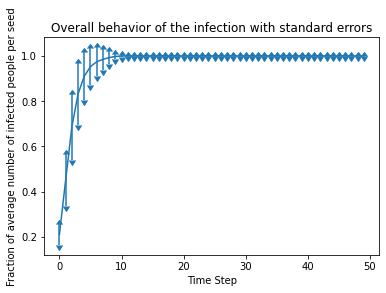

In [4]:
# Plot of average infection numbers per seed with standard errors marked with the arrows
fig2 = plt.figure()
plt.errorbar(list(avg_over_timesteps_final.keys()), np.array(avg)/num_people, yerr = np.array(std)/num_people, uplims=10, lolims=10)
plt.ylabel('Fraction of average number of infected people per seed')
plt.xlabel('Time Step')
plt.title('Overall behavior of the infection with standard errors')
plt.savefig('Overall behavior of the infection with standard errors (20 in 10 by 10)')

In [5]:
# A secondary function to give a rough estimate of number students to be accomodated in a stationary sitting (a classroom) following some norms

# Can we accomodate these many people in a place, assuming them to be almost stationary throughout.

def can_accomodate(place_size, dist_norm, air_space_class=[2, 3], air_space_people=1):
    '''
    place_size (list): [length, breadth]
    dist_norm: min_distance between people to be followed
    air_space_people: comfort+size..etc.
    air_space_class (list): class_room size not used [length, breadth]
    '''        
    return int(((place_size[0]-2*air_space_class[0])*(place_size[1]-2*air_space_class[1]))/((air_space_people/2 + dist_norm)**2))
can_accomodate(place_size=[30, 30], dist_norm=2)

99